In [1]:
tissues_with_atac = [
    'CHO', 'Brain', 'Liver', 'Lung', 'Kidney', 'Spleen', 'BMDMwt', 'BMDM1hKLA'
]

## Parameters specific to where your folders are and your data
parameter_file = 'params/params.yaml'
import yaml
import sys

with open(parameter_file, 'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
annotation = doc['annotation']

tss_annotation = doc['tss_annotation']

import os
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm
### notebook specific configuration ###
from os.path import basename
#mpl.style.use('ggplot')
mpl.style.use('fivethirtyeight')
from cycler import cycler
#mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

from Homer import *

print('Number of tissues: ', len(tissues))

('Number of tissues: ', 15)


In [2]:
import json

In [3]:
#Recommended standards by 
recommended = dict()
recommended['NRF'] = 0.9
recommended['PBC1'] = 0.9
recommended['mapped_pct'] = 80
recommended['FRiP'] = 0.3
recommended['total_reads'] = 25e6
recommended['tissue'] = 'ENCODE Rec'

In [4]:
qc = pd.DataFrame()

qc = qc.append(pd.DataFrame(recommended,index=['Recommended standards']))


for t in tissues_with_atac:

    curr = os.path.join(data_folder,t)
    curr = os.path.join(curr,'ATAC/out/*ENCODE*json')
#     if len(glob.glob(curr)) == 0:
#         print(curr)
#         continue
    curr = glob.glob(curr)[0]
    print(curr)
    with open(curr, 'r') as f:
        datastore = json.load(f)
    #t_dict = dict()
    reps = []
    for i in range(len(datastore['data_files'])):
        d = dict()
        d['tissue'] = t
        reps.append(d)

    count_pcr = 0
    count_sam = 0
    for i in datastore['ENCODE_quality_metrics']:

        if i['ENCODE_qc_type'] == 'complexity_xcorr_quality_metric':
            #print(i)
            reps[count_pcr]['NRF'] = np.float(i['NRF'])
            reps[count_pcr]['PBC1'] = np.float(i['PBC1'])
            count_pcr += 1
        elif i['ENCODE_qc_type'] == 'samtools_flagstats_quality_metric':
            reps[count_sam]['total_reads'] = np.int(i['total'])
            reps[count_sam]['mapped_pct'] = np.float(i['mapped_pct'])
            count_sam += 1

    for i in datastore['qc_files']:
        if i['header'] == 'FRiP' and i['info'] == 'rep1-pr':
            reps[0]['FRiP'] = np.float(i['contents'])
        elif i['header'] == 'FRiP' and i['info'] == 'rep2-pr':
            reps[1]['FRiP'] = np.float(i['contents'])
    #t_dict[]
    for i,r in enumerate(reps):
        qc = qc.append(pd.DataFrame(r,index=[t+'_'+str(i+1)]))
        
#qc = qc.append(pd.DataFrame(recommended,index=['Recommended standards']))
qc = qc[['total_reads','mapped_pct','NRF','PBC1','FRiP','tissue']]

qc


/data/isshamie/TSS/1015_Processed/CHO/ATAC/out/ENCODE_summary.json
/data/isshamie/TSS/1015_Processed/Brain/ATAC/out/ENCODE_summary.json
/data/isshamie/TSS/1015_Processed/Liver/ATAC/out/ENCODE_summary.json
/data/isshamie/TSS/1015_Processed/Lung/ATAC/out/ENCODE_summary.json
/data/isshamie/TSS/1015_Processed/Kidney/ATAC/out/ENCODE_summary.json
/data/isshamie/TSS/1015_Processed/Spleen/ATAC/out/ENCODE_summary.json
/data/isshamie/TSS/1015_Processed/BMDMwt/ATAC/out/ENCODE_summary.json
/data/isshamie/TSS/1015_Processed/BMDM1hKLA/ATAC/out/ENCODE_summary.json


,total_reads,mapped_pct,NRF,PBC1,FRiP,tissue
Recommended standards,25000000.0,80.00,0.900000,0.900000,0.300000,ENCODE Rec
CHO_1,27208801.0,60.18,0.630805,0.953005,0.240991,CHO
CHO_2,36370172.0,59.92,0.599829,0.955556,0.205816,CHO
Brain_1,15275763.0,91.35,0.889809,0.921053,0.358573,Brain
Liver_1,13478699.0,64.68,0.515670,0.646450,0.045708,Liver
Lung_1,13864074.0,76.49,0.857043,0.953086,0.138384,Lung
Kidney_1,23051800.0,82.95,0.822772,0.882024,0.397125,Kidney
Spleen_1,23964666.0,89.68,0.678609,0.681254,0.100485,Spleen
BMDMwt_1,13396299.0,84.43,0.697751,0.919798,0.429631,BMDMwt
BMDMwt_2,16394832.0,65.84,0.851571,0.917288,0.577918,BMDMwt


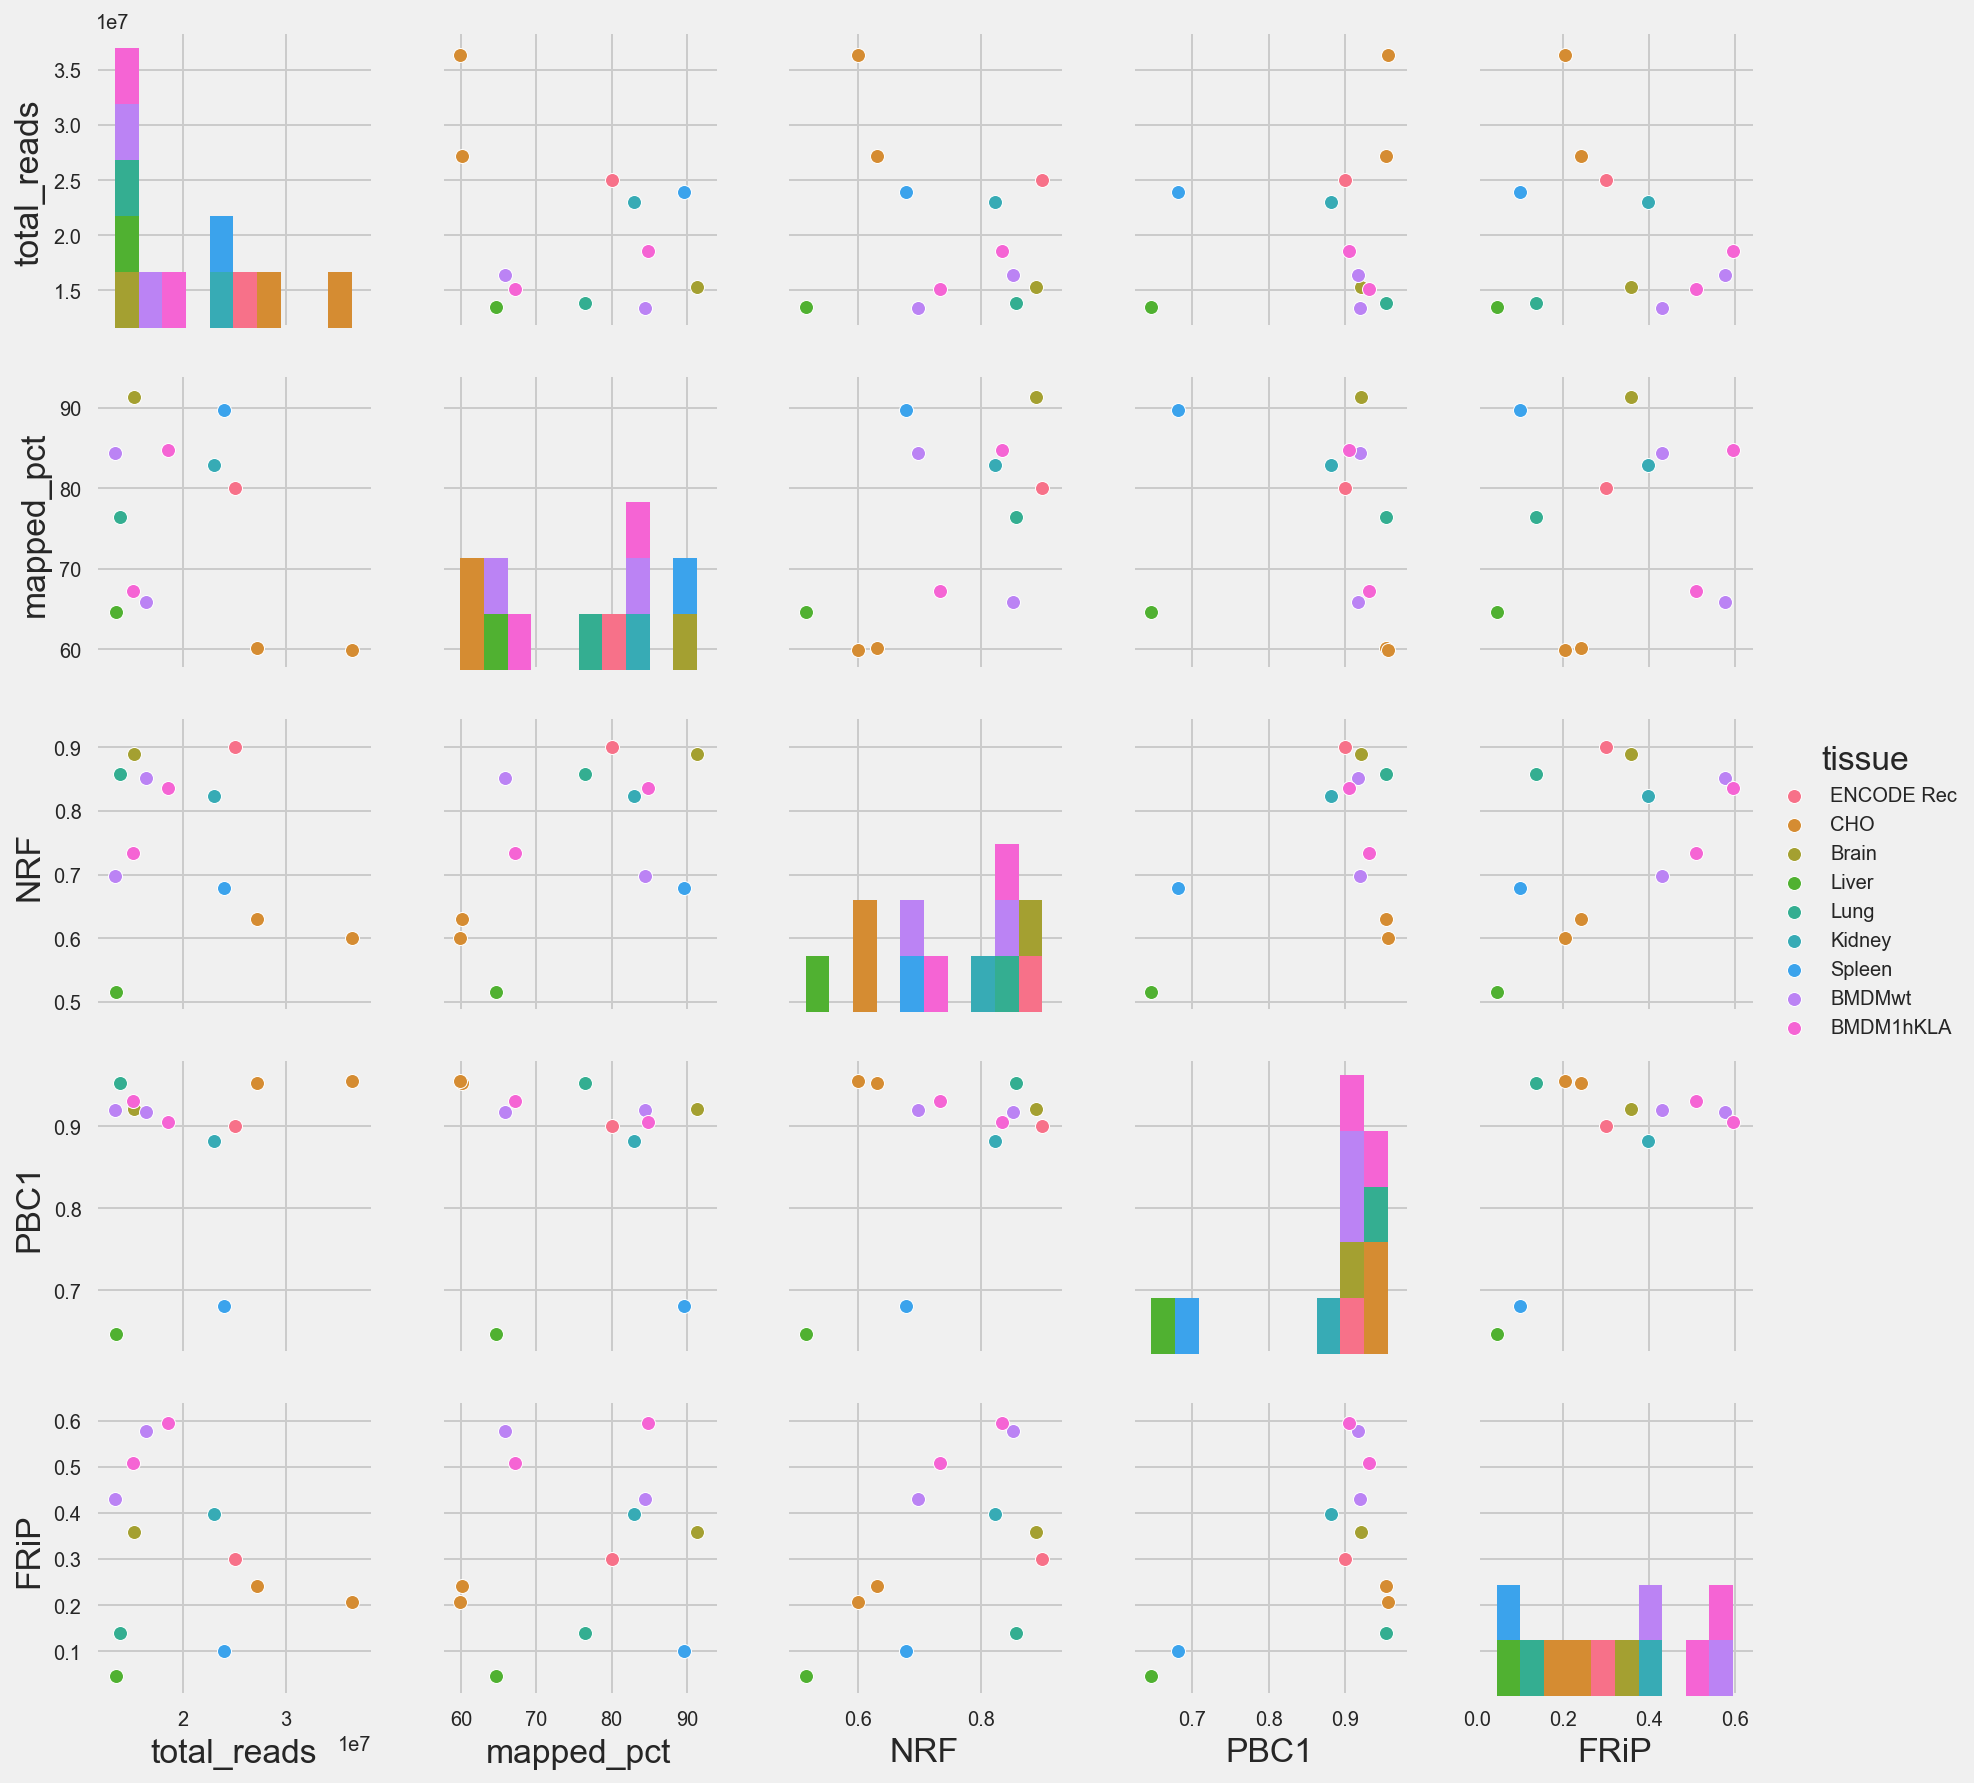

In [5]:
sns.pairplot(qc,hue='tissue')
#plt.savefig('Results/ATAC_results/QC.png')

total_reads
mapped_pct


/home/isshamie/software/anaconda2/lib/python2.7/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


NRF
PBC1
FRiP
tissue


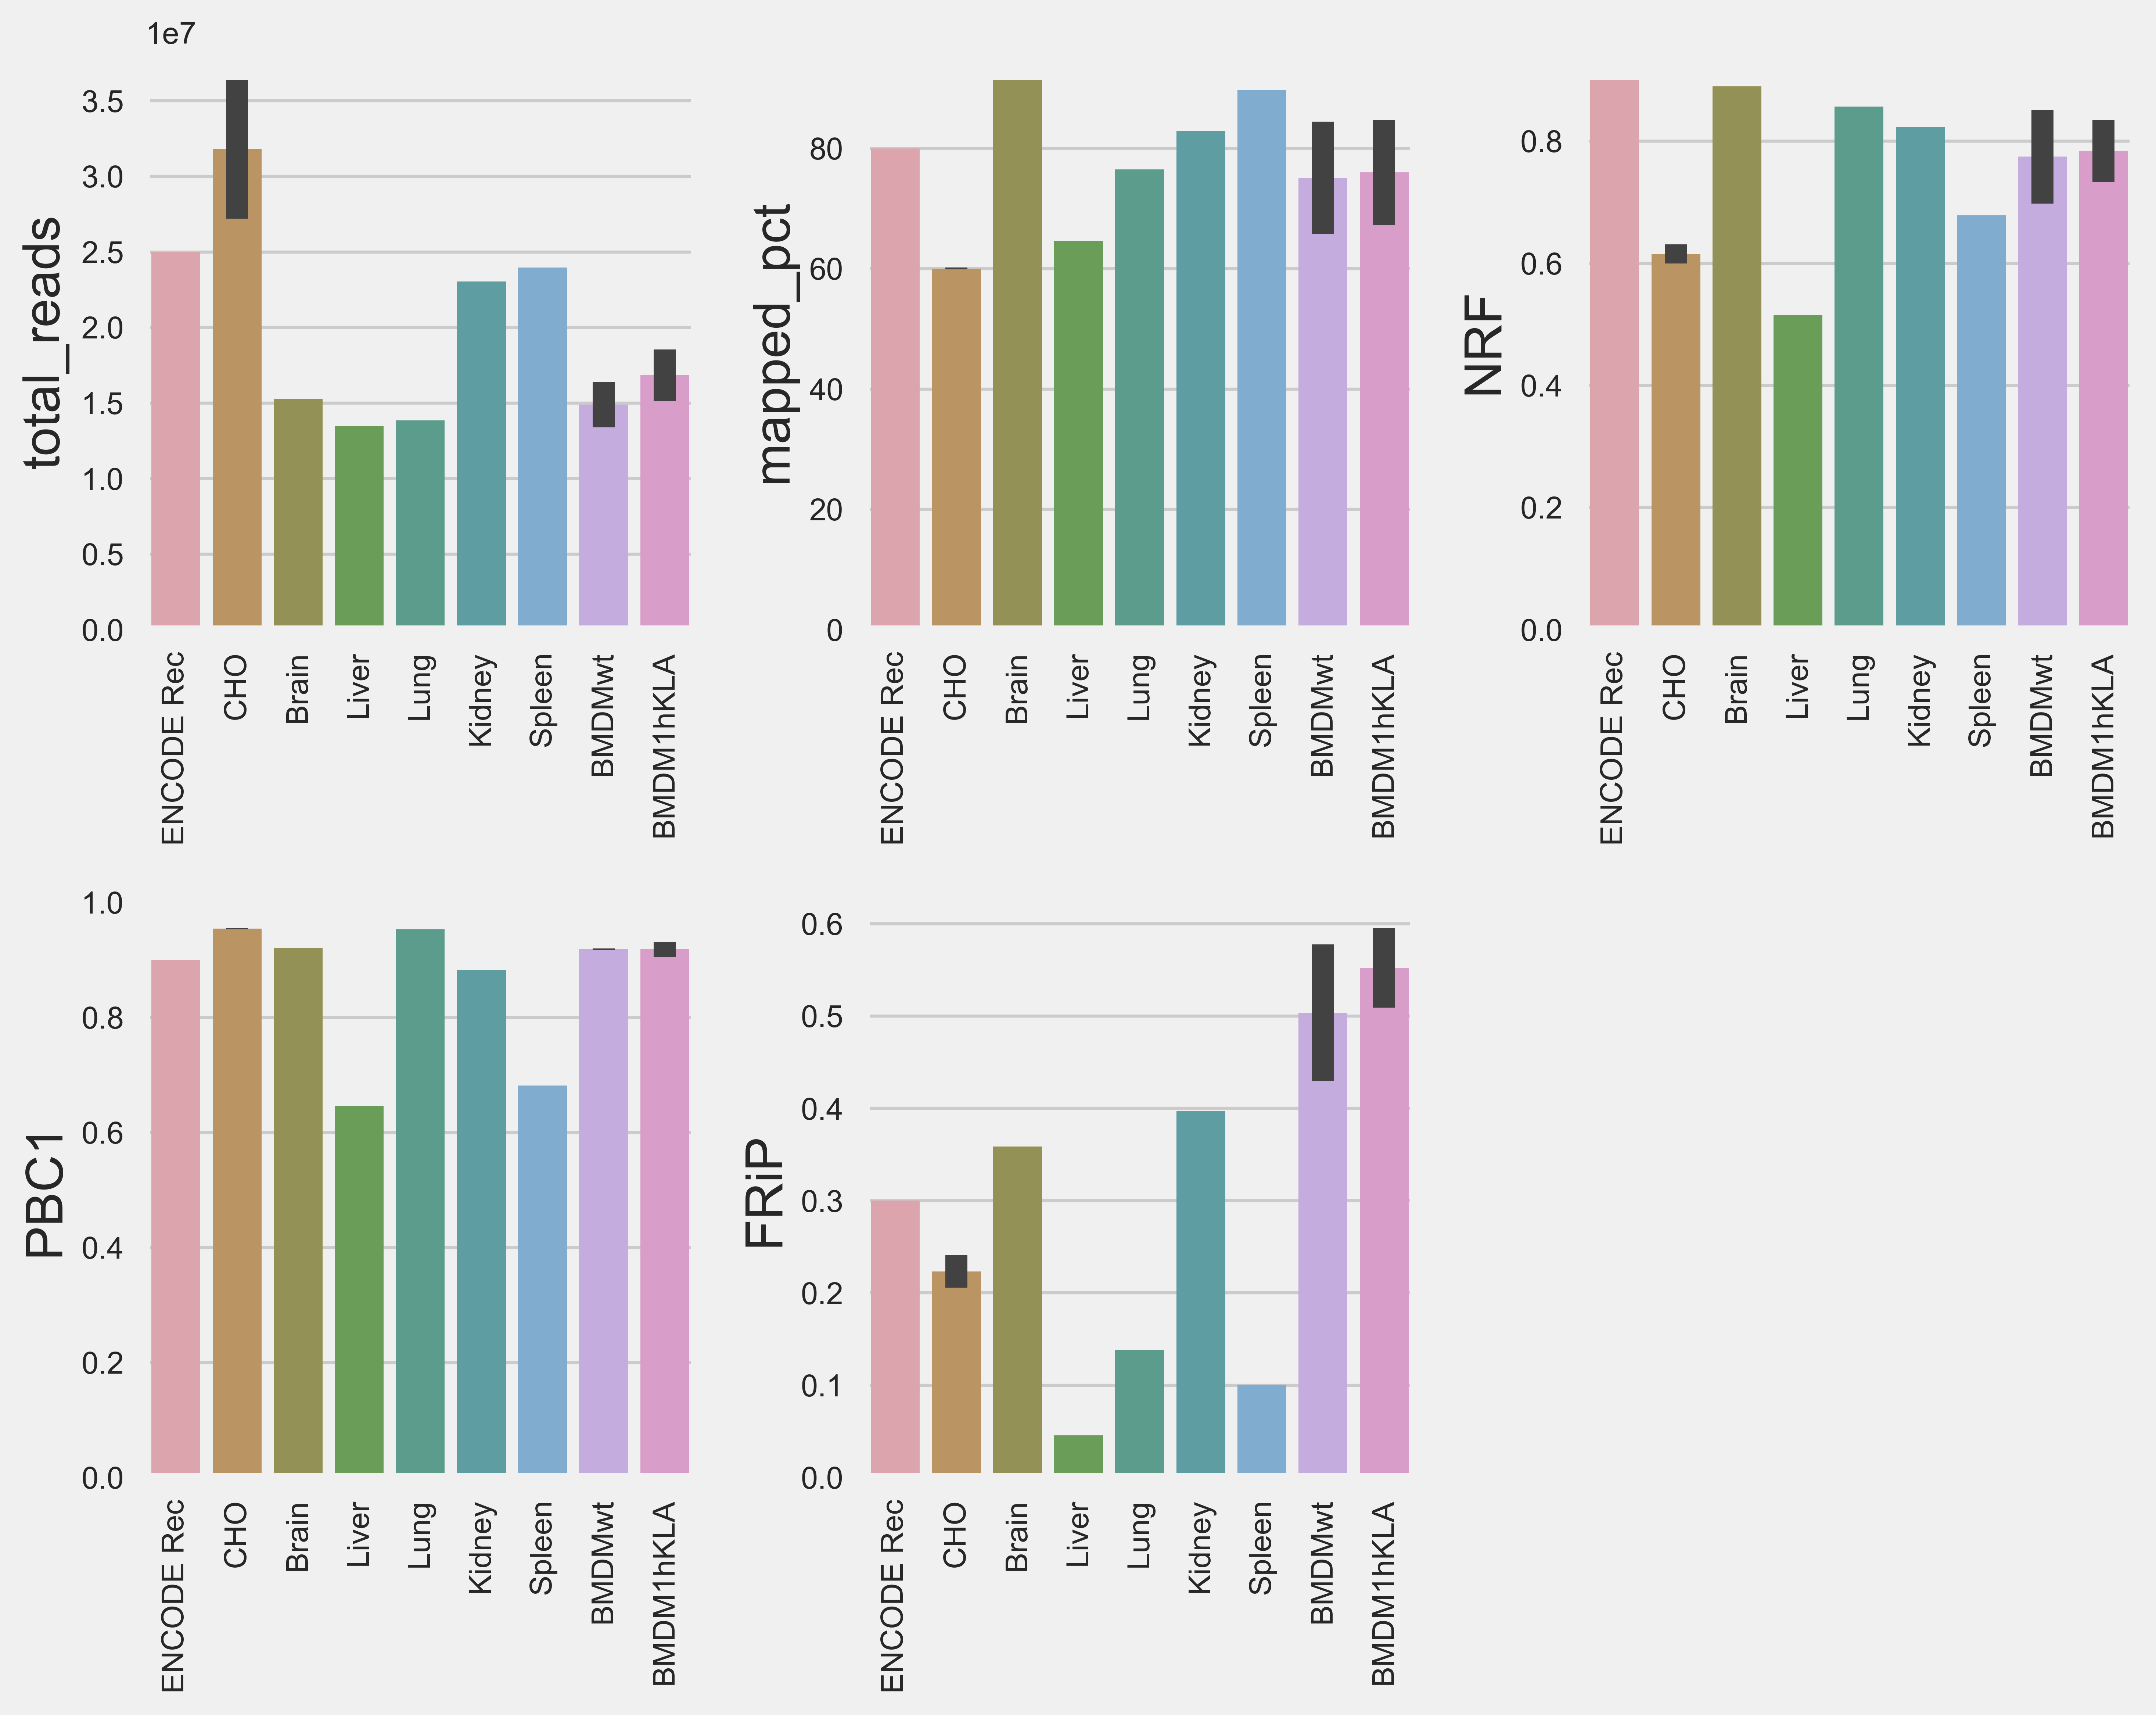

In [6]:
f = plt.figure(figsize=(10,8),dpi=300)
#f = plt.figure()
num_col = len(qc.columns)-1
plt.subplot()
count = 1
for val in (qc.columns):
    print(val)

    if not val == 'tissue':
        plt.subplot(2,int(num_col/2)+1,count)
        f.subplots_adjust(hspace=.5)
        f.subplots_adjust(wspace=1)
        sns.barplot(x="tissue", y=val, 
                 data=qc, saturation=.5,ax=plt.gca())
        plt.xticks(rotation=90)
#         qc.loc[:,val].plot.bar(color='salmon')
        count+=1
        plt.xlabel('')
        plt.ylabel(val)
plt.tight_layout()
#plt.savefig('Results/ATAC_results/QC_bar.png')